In [173]:
from fastai.vision.all import *
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [174]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test']) 

In [175]:
print(train_df.head(), '\n')
print('Train shape:', train_df.shape, '\n')


print(val_df.head(), '\n')
print('Val shape:', val_df.shape, '\n')

          file    age  gender        race
0  train/1.jpg  50-59    Male  East Asian
1  train/2.jpg  30-39  Female      Indian
2  train/3.jpg    3-9  Female       Black
3  train/4.jpg  20-29  Female      Indian
4  train/5.jpg  20-29  Female      Indian 

Train shape: (86744, 4) 

        file    age  gender             race
0  val/1.jpg    3-9    Male       East Asian
1  val/2.jpg  50-59  Female       East Asian
2  val/3.jpg  30-39    Male            White
3  val/4.jpg  20-29  Female  Latino_Hispanic
4  val/5.jpg  20-29    Male  Southeast Asian 

Val shape: (10954, 4) 



In [176]:
age_labels = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern', 'Latino_Hispanic']


def encode_age(age):
    mlb_age = MultiLabelBinarizer(classes=age_labels)
    return mlb_age.fit_transform([[age]]).flatten()

def encode_gender(gender):
    mlb_gender = MultiLabelBinarizer(classes=gender_labels)
    return mlb_gender.fit_transform([[gender]]).flatten()

def encode_race(race):
    mlb_race = MultiLabelBinarizer(classes=race_labels)
    return mlb_race.fit_transform([[race]]).flatten()

def encode_labels(row):
    return np.concatenate([
        encode_age(row['age']),
        encode_gender(row['gender']),
        encode_race(row['race'])
    ])
    
def encode_labels(row):
    return np.concatenate([
        encode_age(row['age']),
        encode_gender(row['gender']),
        encode_race(row['race'])
    ])
    
train_df['encoded_labels'] = train_df.apply(encode_labels, axis=1)
val_df['encoded_labels'] = val_df.apply(encode_labels, axis=1)

In [177]:
def get_labels(row):
    return row['age'], row['gender'], row['race']

fairface_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),   
    get_x=ColReader('file', pref='./Dataset/'),                   
    get_y=ColReader(['age', 'gender', 'race']), 
    splitter=RandomSplitter(seed=42),          
    item_tfms=Resize(224),                     
    batch_tfms=aug_transforms(mult=1.0, max_rotate=20.0, max_zoom=1.2, max_warp=0.2, p_affine=0.75)     
)

dls = fairface_block.dataloaders(train_df, bs=64)

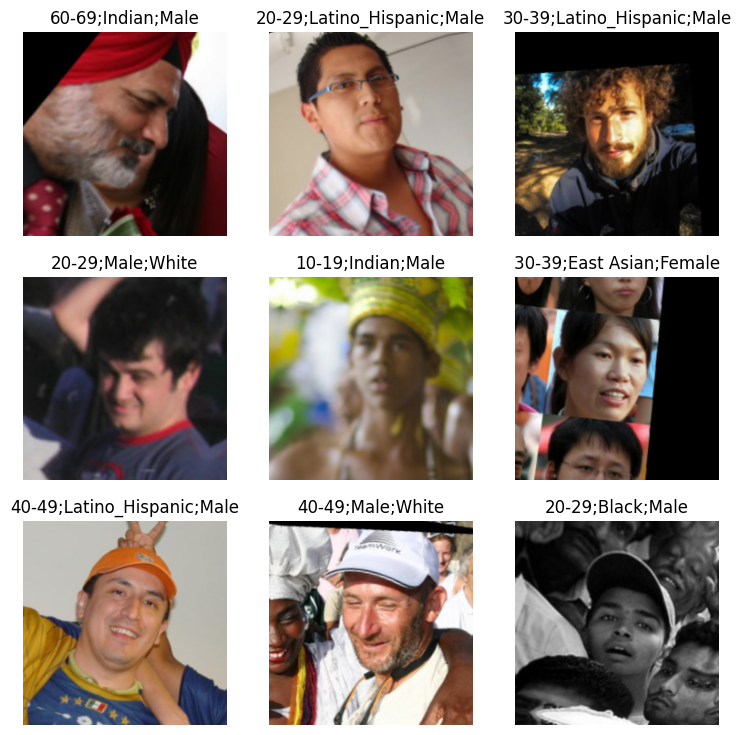

In [178]:
dls.show_batch()

In [179]:
learn = vision_learner(dls, resnet34, metrics=[accuracy_multi])  

In [180]:
learn.fine_tune(10, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.333824,0.300978,0.876489,05:31


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.263651,0.242577,0.896001,07:36
1,0.236403,0.219947,0.903991,07:53
2,0.217395,0.208754,0.908350,07:59
3,0.205801,0.199405,0.911895,08:02
4,0.193797,0.194077,0.913986,07:50
5,0.182155,0.191377,0.915072,07:39
6,0.175249,0.189351,0.916884,07:51
7,0.166222,0.188183,0.917413,07:39
8,0.159559,0.188237,0.917788,07:39
9,0.158008,0.187973,0.917813,07:55


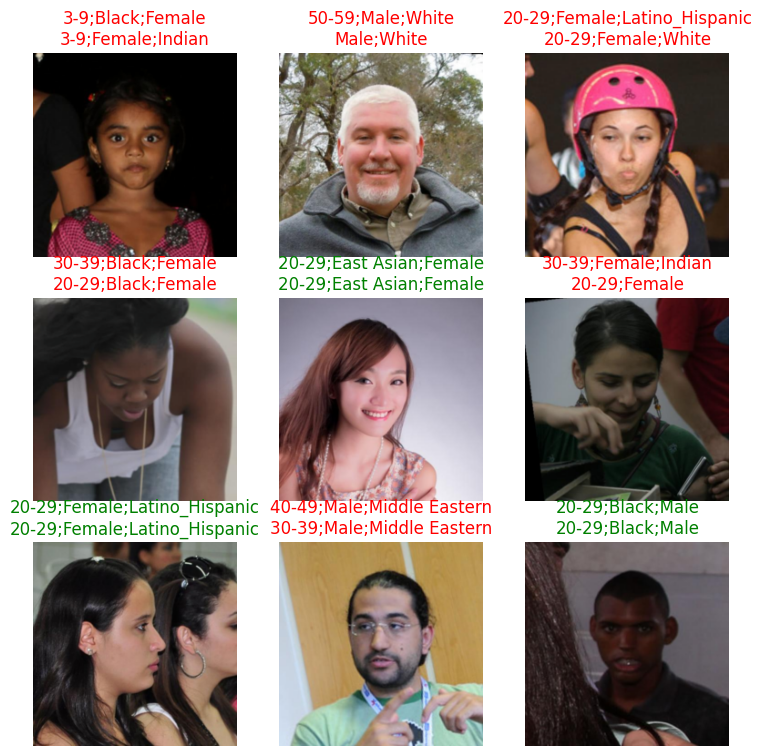

In [181]:
learn.show_results()

In [185]:
img = PILImage.create('./Dataset/val/71.jpg')
pred, pred_idx, probs = learn.predict(img)

age_probs = probs[:len(age_labels)]
gender_probs = probs[len(age_labels):len(age_labels) + len(gender_labels)]
race_probs = probs[len(age_labels) + len(gender_labels):]

print("Age Category Probabilities:")
for label, prob in zip(age_labels, age_probs):
    print(f'{label}: {prob:.4f}')

print("\nGender Category Probabilities:")
for label, prob in zip(gender_labels, gender_probs):
    print(f'{label}: {prob:.4f}')

print("\nRace Category Probabilities:")
for label, prob in zip(race_labels, race_probs):
    print(f'{label}: {prob:.4f}')

Age Category Probabilities:
0-2: 0.0000
3-9: 0.0003
10-19: 0.0001
20-29: 0.0003
30-39: 0.0003
40-49: 0.0042
50-59: 0.1060
60-69: 0.5906
more than 70: 0.0032

Gender Category Probabilities:
Male: 0.0005
Female: 0.0005

Race Category Probabilities:
White: 0.0210
Black: 0.0476
East Asian: 0.9995
Southeast Asian: 0.8344
Indian: 0.0010
Middle Eastern: 0.0715
Latino_Hispanic: 0.2011


In [186]:
learn.export('../models/fairface_v1.pkl')

In [187]:
torch.save(learn.model.state_dict(), '../models/fairface_v1.pth')